In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score

In [3]:
# -------------------------
# 1. Data Preprocessing
# -------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten to 1D vector (784,)
])

mnist_train = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Convert to numpy arrays
train_images = np.array([mnist_train[i][0].numpy() for i in range(len(mnist_train))])
train_labels = np.array([mnist_train[i][1] for i in range(len(mnist_train))])

test_images = np.array([mnist_test[i][0].numpy() for i in range(len(mnist_test))])
test_labels = np.array([mnist_test[i][1] for i in range(len(mnist_test))])

# Select only digit 8 for training
normal_digit = 8  # Change this to your roll number's last digit
train_images_normal = train_images[train_labels == normal_digit]

# Convert to PyTorch tensors
train_tensor = torch.tensor(train_images_normal, dtype=torch.float32)
test_tensor = torch.tensor(test_images, dtype=torch.float32)


In [4]:
# -------------------------
# 2. Define Autoencoder
# -------------------------
class Autoencoder(nn.Module):
    def __init__(self, input_dim=784, encoding_dim=32):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, encoding_dim),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)


In [5]:
# -------------------------
# 3. Train the Autoencoder
# -------------------------
num_epochs = 10
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_tensor, batch_size=batch_size, shuffle=True)

autoencoder.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        output = autoencoder(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")


Epoch [1/10], Loss: 0.1097
Epoch [2/10], Loss: 0.0592
Epoch [3/10], Loss: 0.0518
Epoch [4/10], Loss: 0.0451
Epoch [5/10], Loss: 0.0398
Epoch [6/10], Loss: 0.0367
Epoch [7/10], Loss: 0.0346
Epoch [8/10], Loss: 0.0319
Epoch [9/10], Loss: 0.0295
Epoch [10/10], Loss: 0.0281


In [6]:
# -------------------------
# 4. Compute Reconstruction Errors
# -------------------------
autoencoder.eval()
with torch.no_grad():
    predictions = autoencoder(test_tensor)  # Reconstruct test images
reconstruction_errors = torch.mean((test_tensor - predictions) ** 2, dim=1).numpy()

# Separate errors for normal (digit 8) and anomalous (other digits)
normal_errors = reconstruction_errors[test_labels == normal_digit]
anomaly_errors = reconstruction_errors[test_labels != normal_digit]

threshold = np.percentile(normal_errors, 95)
print(f"Chosen threshold: {threshold:.6f}")


Chosen threshold: 0.047302


In [7]:
# -------------------------
# 5. Evaluate Model Performance
# -------------------------
y_true = (test_labels != normal_digit).astype(int)  # 1 for anomaly, 0 for normal

y_pred = (reconstruction_errors > threshold).astype(int)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Precision: 0.9913
Recall: 0.6156
F1-score: 0.7595


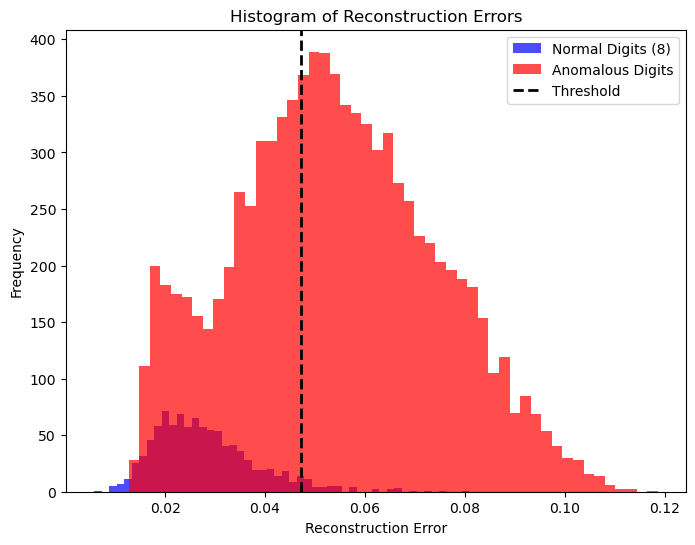

In [8]:
# -------------------------
# 5. Plot Histogram
# -------------------------
plt.figure(figsize=(8,6))
plt.hist(normal_errors, bins=50, alpha=0.7, label="Normal Digits (8)", color='blue')
plt.hist(anomaly_errors, bins=50, alpha=0.7, label="Anomalous Digits", color='red')
plt.axvline(threshold, color='black', linestyle='dashed', linewidth=2, label='Threshold')
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.title("Histogram of Reconstruction Errors")
plt.show()


In [9]:
# -------------------------
# 6. Hyperparameter Tuning - Compare Encoding Dimensions
# -------------------------
encoding_dims = [8, 45, 75]
roc_results = {}

for dim in encoding_dims:
    model = Autoencoder(encoding_dim=dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            output = model(batch)
            loss = criterion(output, batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    
    model.eval()
    with torch.no_grad():
        predictions = model(test_tensor)
    reconstruction_errors = torch.mean((test_tensor - predictions) ** 2, dim=1).cpu().detach().numpy()
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, reconstruction_errors)
    roc_auc = auc(fpr, tpr)
    roc_results[dim] = (fpr, tpr, roc_auc)
    print(f"Encoding Dimension {dim}: AUC-ROC = {roc_auc:.4f}")


Encoding Dimension 8: AUC-ROC = 0.8718
Encoding Dimension 45: AUC-ROC = 0.8820
Encoding Dimension 75: AUC-ROC = 0.8749


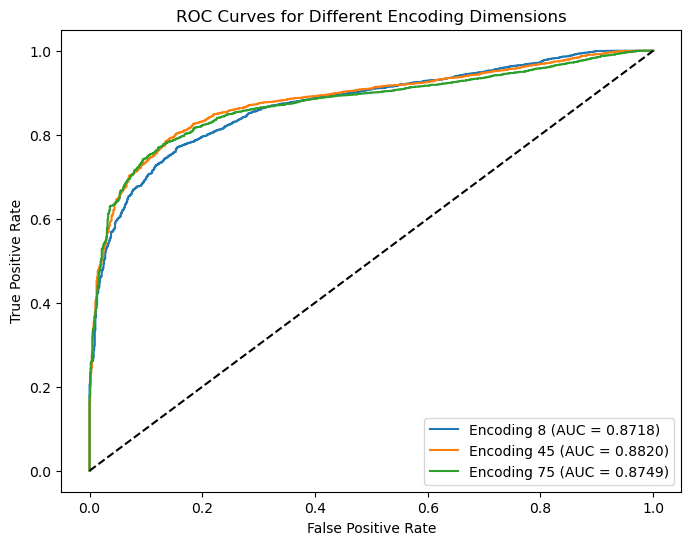

In [10]:
plt.figure(figsize=(8,6))
for dim, (fpr, tpr, roc_auc) in roc_results.items():
    plt.plot(fpr, tpr, label=f"Encoding {dim} (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curves for Different Encoding Dimensions")
plt.show()


Observations : 
1. The reconstruction error for normal digits is very less compared to anamolous digits
reconstruction error for normal digits would be averaged at 0.025 approximately and for anamolous digits would be at 0.05
2. Also the peak of distribution for reconstruction error for anamolous digits is way more higher compared to normal digits.
3. The threshold I considered is with 95% interval which gives the threshold as 0.048, the model is very precise, meaning that most of the data points it classifies as anomalous are truly anomalous.
4. Recall measures how many of the actual anomalous data points were correctly identified by the model. The recall value of 0.6156 is relatively lower than precision, meaning the model is missing around 38% of the true anomalies (i.e., false negatives). This indicates that while the model is good at not misclassifying normal digits as anomalies, it struggles to detect all the anomalous digits correctly.  
5. The F1-score of 0.7595 suggests that the model has a reasonably good balance between precision and recall.

-----------------------------------------------------------------------------------

Observations on Hyperparameter Tuning (Bottleneck Dimensions and AUC-ROC Score):
Encoding Dimension 8: AUC-ROC = 0.8718

A bottleneck dimension of 8 yields an AUC-ROC of 0.8718, suggesting decent performance, but with potential loss of information due to the small dimension.
Encoding Dimension 45: AUC-ROC = 0.8820

The encoding dimension of 45 achieves the highest AUC-ROC score (0.8820), indicating a good balance between compression and model performance for anomaly detection.
Encoding Dimension 75: AUC-ROC = 0.8749

With a dimension of 75, the AUC-ROC score is 0.8749, slightly lower than for 45. This shows diminishing returns as the model becomes more complex without significant performance gains.
Conclusion:
Best Performance: The encoding dimension of 45 provides the best AUC-ROC score, balancing compression and performance.
Diminishing Returns: Larger dimensions (75) show minimal improvement, suggesting that dimension 45 is optimal for anomaly detection.